## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'utils/datasets/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048757


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

Hint: Connect to probability.

## Answer:

This makes sense because 2.3 is approximately -log(1/10), which corresponds to a uniform probability across the 10 classes. The softmax model is essentially guessing right now.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.573874 analytic: -0.573874, relative error: 9.682948e-10
numerical: 1.110352 analytic: 1.110352, relative error: 3.633557e-09
numerical: 0.551602 analytic: 0.551602, relative error: 9.119113e-09
numerical: 0.902114 analytic: 0.902114, relative error: 2.085847e-08
numerical: 0.623967 analytic: 0.623967, relative error: 5.346284e-08
numerical: 0.261285 analytic: 0.261285, relative error: 1.721958e-07
numerical: -0.012615 analytic: -0.012615, relative error: 5.033581e-06
numerical: -0.803946 analytic: -0.803946, relative error: 1.607864e-08
numerical: 0.411362 analytic: 0.411362, relative error: 2.556349e-08
numerical: -3.081797 analytic: -3.081797, relative error: 2.006334e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.309703797011348 / 298.26960159068284 computed in 0.012566089630126953s
Vectorized loss / grad: 2.309703797011348 / 298.26960159068284 computed in 0.0036971569061279297s
difference in loss / grad: 0.0 /0.0 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981612
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.8532611454359382
iteration 700 / 1500: loss 1.835306222372583
iteration 800 / 1500: loss 1.8293892468827635
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.97835035402523
iteration 1100 / 1500: loss 1.847079791353263
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 3.0946781635284424s


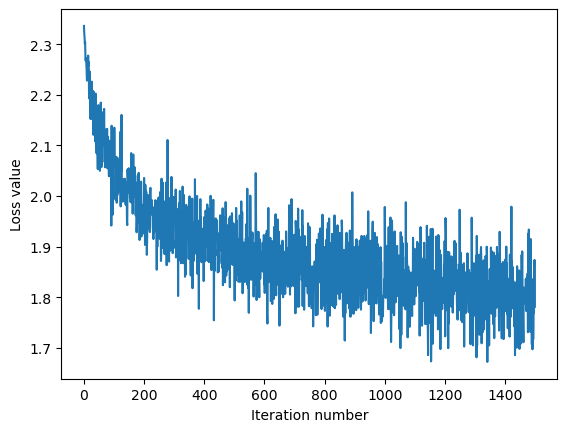

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

In [12]:
np.finfo(float).eps

np.float64(2.220446049250313e-16)

In [25]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested, determined by best validation accuracy.  
#     - The best validation accuracy.
#     - Select the model that achieved the best validation accuracy and report
#       its accuracy on the test set.
# ================================================================ #
lrs = np.logspace(-7, -3, 5)
lr_errs = np.zeros_like(np.array(lrs), dtype=float)
for j, lr in enumerate(lrs):
    softmax.train(X_train, y_train, learning_rate=lr, num_iters=1000)
    y_pred = softmax.predict(X_val)
    lr_errs[j] = np.mean(y_pred != y_val)

best_lr = lrs[np.argmin(lr_errs)]
best_lr_err = np.min(lr_errs)
softmax.train(X_train, y_train, learning_rate=best_lr, num_iters=1000)
best_y_pred = softmax.predict(X_val)
best_lr_acc = np.mean(best_y_pred == y_val)
best_y_pred_test = softmax.predict(X_test)
best_lr_test_acc = np.mean(best_y_pred_test == y_test)
print(f'Best LR = {best_lr}, corresponding validation accuracy = {best_lr_acc}, corresponding test accuracy = {best_lr_test_acc}')
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


/Users/sophiatsoukalas/Library/Mobile Documents/com~apple~CloudDocs/UCLA/YEAR 4/W26/EC ENGR C147A/hw2/nndl/softmax.py:80: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
/Users/sophiatsoukalas/Library/Mobile Documents/com~apple~CloudDocs/UCLA/YEAR 4/W26/EC ENGR C147A/hw2/nndl/softmax.py:81: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # (N,C)
/Users/sophiatsoukalas/Library/Mobile Documents/com~apple~CloudDocs/UCLA/YEAR 4/W26/EC ENGR C147A/hw2/nndl/softmax.py:83: RuntimeWarning: divide by zero encountered in log
  logprobs = -np.log(probs[np.arange(N), y])


Best LR = 1e-06, corresponding validation accuracy = 0.404, corresponding test accuracy = 0.397
